### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [3]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# Pre-processing
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10) 

In [5]:
# Dense Block
def denseblock(input, num_filter = 32):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat
        
    return temp

# transition Block
def transition(input, num_filter = 32):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [6]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 20
l = 5
num_filter = 45
compression = 0.92

In [7]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter)
First_Transition = transition(First_Block, num_filter)

Second_Block = denseblock(First_Transition, num_filter)
Second_Transition = transition(Second_Block, num_filter)

Third_Block = denseblock(Second_Transition, num_filter)
Third_Transition = transition(Third_Block, num_filter)

Last_Block = denseblock(Third_Transition,  num_filter)
output = output_layer(Last_Block)

2022-12-08 09:25:34.845625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 09:25:34.846464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 09:25:34.856829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 09:25:34.857643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 09:25:34.858385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [8]:
model = Model(input, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 45)   1215        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 45)   180         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 45)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
print(len(model.layers))

99


In [10]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

### Image Augmentation

In [11]:
# ref: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            rotation_range=25,  
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.1,
            zoom_range=0.15,
            fill_mode='nearest',
            horizontal_flip=True
)

In [12]:
datagen.fit(X_train)


# fits the model on batches with real-time data augmentation:
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                 validation_data=datagen.flow(X_test, y_test),
                 steps_per_epoch=len(X_train) / 128, epochs=215)

2022-12-08 09:25:37.849928: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/215


2022-12-08 09:25:41.017274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


390/390 [==============================] - 71s 162ms/step - loss: 1.5476 - accuracy: 0.4352 - val_loss: 2.2533 - val_accuracy: 0.2697
Epoch 2/215
390/390 [==============================] - 60s 153ms/step - loss: 1.1662 - accuracy: 0.5813 - val_loss: 1.5167 - val_accuracy: 0.5070
Epoch 3/215
390/390 [==============================] - 59s 152ms/step - loss: 0.9629 - accuracy: 0.6590 - val_loss: 1.2649 - val_accuracy: 0.5681
Epoch 4/215
390/390 [==============================] - 63s 161ms/step - loss: 0.8474 - accuracy: 0.7040 - val_loss: 1.1419 - val_accuracy: 0.6277
Epoch 5/215
390/390 [==============================] - 60s 152ms/step - loss: 0.7653 - accuracy: 0.7330 - val_loss: 1.0793 - val_accuracy: 0.6335
Epoch 6/215
390/390 [==============================] - 60s 154ms/step - loss: 0.7027 - accuracy: 0.7544 - val_loss: 1.0204 - val_accuracy: 0.6462
Epoch 7/215
390/390 [==============================] - 60s 152ms/step - loss: 0.6566 - accuracy: 0.7705 - val_loss: 1.0136 - val_accurac

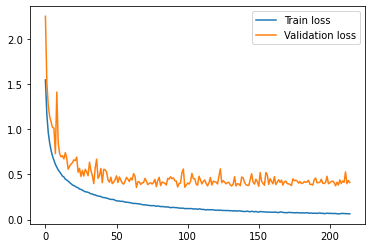

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.legend()
plt.show()

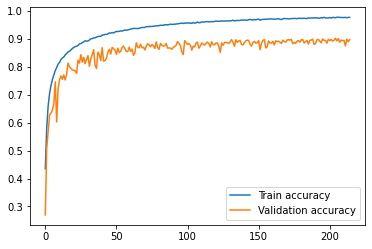

In [14]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')

plt.legend()
plt.show()

In [15]:
res = history.history['val_accuracy']
val_accuracy = max(res)

print('Validation Accuracy: ', val_accuracy)

Validation Accuracy:  0.9023000001907349


In [26]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [27]:
import numpy as np

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test),axis=1)

y = np.argmax(y_test, axis=1)
cm = tf.math.confusion_matrix(labels=y, predictions=y_pred).numpy()

In [28]:
import pandas as pd
pd.set_option('max_columns', None)

con_mat_df = pd.DataFrame(cm, index = labels, columns = labels)
print(con_mat_df)

            airplane  automobile  bird  cat  deer  dog  frog  horse  ship  \
airplane         911          14     4    3     3    0     1      1    33   
automobile         0         980     1    0     0    0     0      0     1   
bird              31          13   885   10    13    7    21      5     8   
cat               17          18    24  809    27   37    30      6     9   
deer               7           6    34    6   913    3    16     10     2   
dog                7          19    27   94    20  784    23     13     2   
frog               5           9    13    7     3    0   954      0     4   
horse              7           9     8    5    24   16     6    918     1   
ship              20          15     2    1     0    0     1      0   941   
truck              4          46     0    0     0    0     0      0     7   

            truck  
airplane       30  
automobile     18  
bird            7  
cat            23  
deer            3  
dog            11  
frog        